<a href="https://colab.research.google.com/github/therohithborana/SOM-Image-Clustering-Analysis/blob/main/SOM_Image_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Self-Organizing Maps (SOM) for Image Clustering

This notebook demonstrates how to use a Self-Organizing Map (SOM) to cluster colors in an image while preserving the original image quality. It also visualizes color density using a scatter plot.

---


## Install and Import Dependencies

### Install Required Library
```python
!pip install minisom


In [1]:
# Install and Import Dependencies
!pip install minisom
import cv2
import numpy as np
import matplotlib.pyplot as plt
from minisom import MiniSom
from tqdm import tqdm
from collections import Counter


  Preparing metadata (setup.py) ... done
  Created wheel for minisom: filename=MiniSom-2.3.5-py3-none-any.whl size=12031 sha256=20061fb1dd3d6d12af34e58a8932a3dcf3d4f7ed1cbde55513a2e0801946362c
  Stored in directory: /root/.cache/pip/wheels/19/db/95/5e53bc2b88a328217fdf9f2886cafbe86b0df274f4b601f572
Successfully built minisom


## Load Image

- Define the path of the image and ensure it is uploaded to the Colab environment.
- Read the image using OpenCV.
- Convert the image from OpenCV’s default BGR format to RGB for correct color representation.

In [4]:

# Load Image
image_path = "/content/nature.jpg"  # Ensure the image is uploaded
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB



In [6]:
# Preserve the original image dimensions
height, width, _ = image.shape

## Resize and Normalize Image

- Resize the image to a fixed dimension to ensure uniform processing.
- Reshape the image into a 2D array where each pixel is represented by its RGB values.
- Normalize the pixel values by scaling them between 0 and 1 to improve clustering performance.


In [7]:
# Reshape image to a 2D array of pixels (N x 3)
pixels = image.reshape(-1, 3)  # Flatten the image
pixels = pixels / 255.0  # Normalize RGB values to [0,1]



## Initialize and Train the Self-Organizing Map (SOM)

- Define the grid size for the SOM.
- Initialize the SOM with random weights.
- Train the SOM using the pixel data, allowing it to group similar colors together.

In [8]:
# Initialize SOM
som_shape = (10, 10)  # Define SOM grid size
som = MiniSom(som_shape[0], som_shape[1], 3, sigma=1.0, learning_rate=0.5)
som.random_weights_init(pixels)



## Generate Quantized Image

- Replace each pixel in the image with the closest SOM cluster color.
- Convert the clustered values back to an image format.
- Ensure the final quantized image retains the correct dimensions.

Training SOM:   0%|          | 0/1000 [00:00<?, ?it/s]

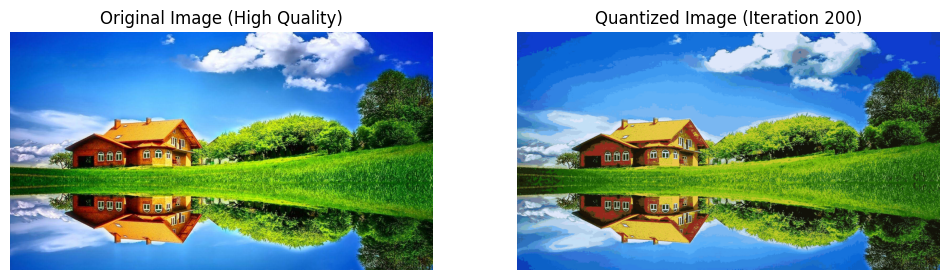

Training SOM:  20%|██        | 200/1000 [00:28<01:54,  6.97it/s]

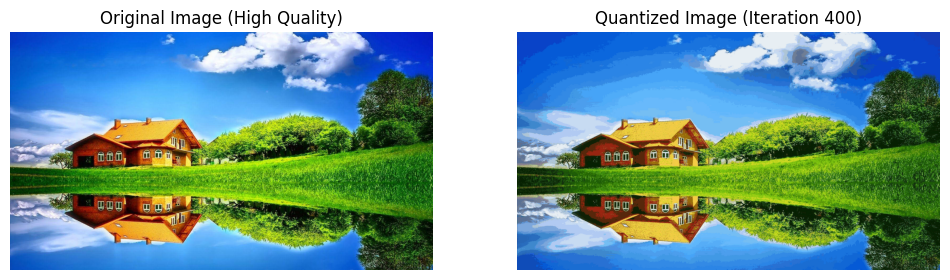

Training SOM:  40%|████      | 400/1000 [00:57<01:26,  6.96it/s]

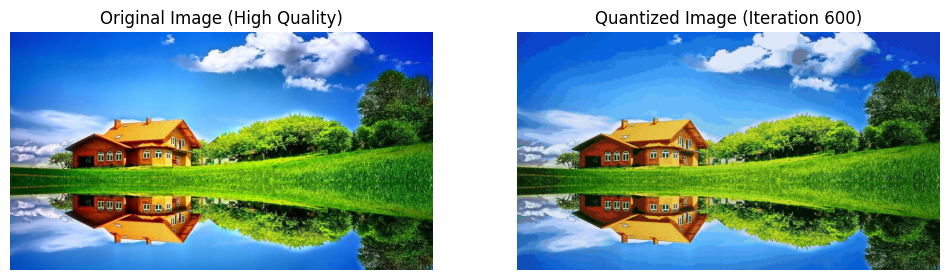

Training SOM:  60%|██████    | 600/1000 [01:29<01:00,  6.61it/s]

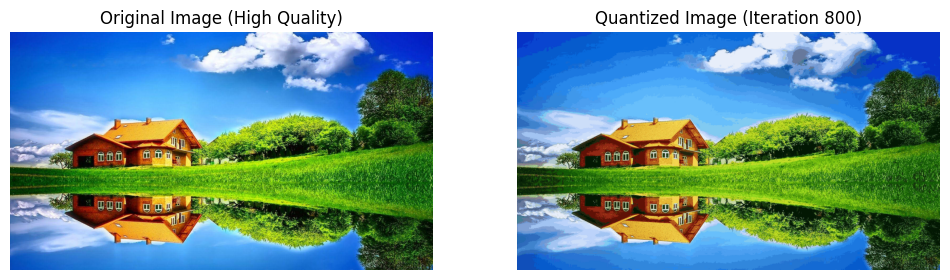

Training SOM:  80%|████████  | 800/1000 [01:58<00:29,  6.74it/s]

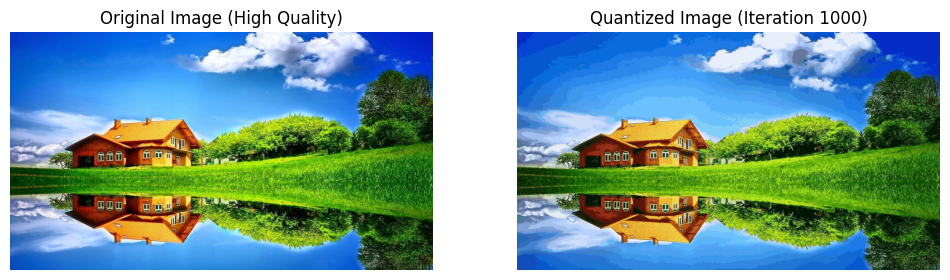

Training SOM: 100%|██████████| 1000/1000 [02:26<00:00,  6.82it/s]


In [9]:
# Training Loop (Updating Weights Manually)
iterations = 1000
update_interval = 200  # Update visualization every 200 iterations

for i in tqdm(range(iterations), desc="Training SOM"):
    rand_index = np.random.randint(0, pixels.shape[0])  # Pick a random pixel
    som.update(pixels[rand_index], som.winner(pixels[rand_index]), i, iterations)  # Update SOM weights
        # Generate and display quantized image at intervals
    if (i + 1) % update_interval == 0 or i == iterations - 1:
        # Compute BMUs for current SOM state
        bmu_list = np.array([som.winner(pixel) for pixel in pixels])
        som_weights = som.get_weights()
        quantized_pixels = np.array([som_weights[bmu[0], bmu[1]] for bmu in bmu_list])

        # Convert back to 0-255 range and reshape
        quantized_pixels = (quantized_pixels * 255).astype(np.uint8)
        quantized_image = quantized_pixels.reshape(height, width, 3)

        # Display current state
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))

        # Show Original Image (High Quality)
        axes[0].imshow(image)
        axes[0].set_title("Original Image (High Quality)")
        axes[0].axis("off")

        # Show Quantized Image
        axes[1].imshow(quantized_image)
        axes[1].set_title(f"Quantized Image (Iteration {i+1})")
        axes[1].axis("off")

        plt.show()




## Compute and Plot Color Density

- Count the frequency of each unique color in the clustered image.
- Plot a graph where each unique color is represented as a point, with the size indicating its density in the image.

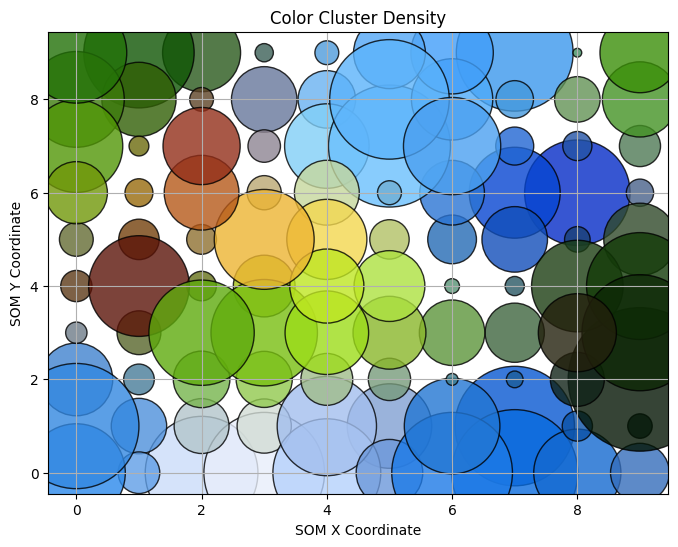

In [10]:
# =========================
# COLOR DENSITY PLOT
# =========================

# Count occurrences of each cluster
bmu_counts = Counter(map(tuple, bmu_list))  # Convert to tuples for counting
cluster_centers = np.array(list(bmu_counts.keys()))  # Unique clusters
cluster_sizes = np.array(list(bmu_counts.values()))  # Frequency of each cluster

# Get colors for each cluster from SOM weights
cluster_colors = np.array([som_weights[bmu[0], bmu[1]] for bmu in cluster_centers])
cluster_colors = (cluster_colors * 255).astype(np.uint8)  # Convert back to 0-255 range

# Plot color density
plt.figure(figsize=(8, 6))
plt.scatter(
    cluster_centers[:, 0],  # X-axis (SOM x-coordinates)
    cluster_centers[:, 1],  # Y-axis (SOM y-coordinates)
    s=cluster_sizes / 5,  # Size of dots scaled by frequency
    c=cluster_colors / 255,  # Convert colors to normalized RGB
    edgecolors="black",
    alpha=0.8
)

plt.xlabel("SOM X Coordinate")
plt.ylabel("SOM Y Coordinate")
plt.title("Color Cluster Density")
plt.grid(True)
plt.show()
